In [34]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import scipy.stats as stats
from scipy.optimize import curve_fit
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [57]:
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':18.,'lonmin':67.,'lonmax':72.5}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Northern Bay of Bengal':{'latmin':18.,'latmax':21.5,'lonmin':87.5,'lonmax':90.},
    'Central Bay of Bengal':{'latmin':8.5,'latmax':15.,'lonmin':86.,'lonmax':90.}} 
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
CASES   = [(6,'June','#A3DEC6'),(7,'July','#2C9A97'),(8,'August','#183441')]
SAMPLETHRESH = 50

In [43]:
def open_dataset(filename,multi=False,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    if multi==True:
        ds = xr.open_mfdataset(filepath)
    else:
        ds = xr.open_dataset(filepath)
    return ds

ds1 = open_dataset('processed/binned_stats.nc')
ds2 = open_dataset('interim/OBS_bl-pr_*.nc',multi=True)

In [44]:
def interp_from_fit(xfit,yfit,x):
    f = get_fit(xfit,yfit)
    y = f(x.values.flatten())
    interped = xr.DataArray(y.reshape(x.shape),dims=x.dims,coords=x.coords)
    return interped

def get_fit(x,y):   
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    def expfunc(x,a,b,c):
        return a*np.exp(b*x)+c
    params,_  = curve_fit(f=expfunc,xdata=x,ydata=y,maxfev=20000)
    a,b,c = params
    f = lambda x: a*np.exp(b*x)+c
    return f

def get_bin_mean_pr(monthstats,samplethresh=SAMPLETHRESH):
    Q0 = monthstats.Q0
    Q1 = monthstats.Q1
    Q0[Q0==0.0] = np.nan
    Q = Q1/Q0
    Q[Q0<samplethresh] = np.nan
    return Q

def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def calc_monthly_mean(ds):
    return ds.groupby('time.month').mean('time').squeeze()

def calc_regional_mean(ds):
    return (ds*np.cos(np.deg2rad(ds.lat))).mean(dim=['lat','lon'])

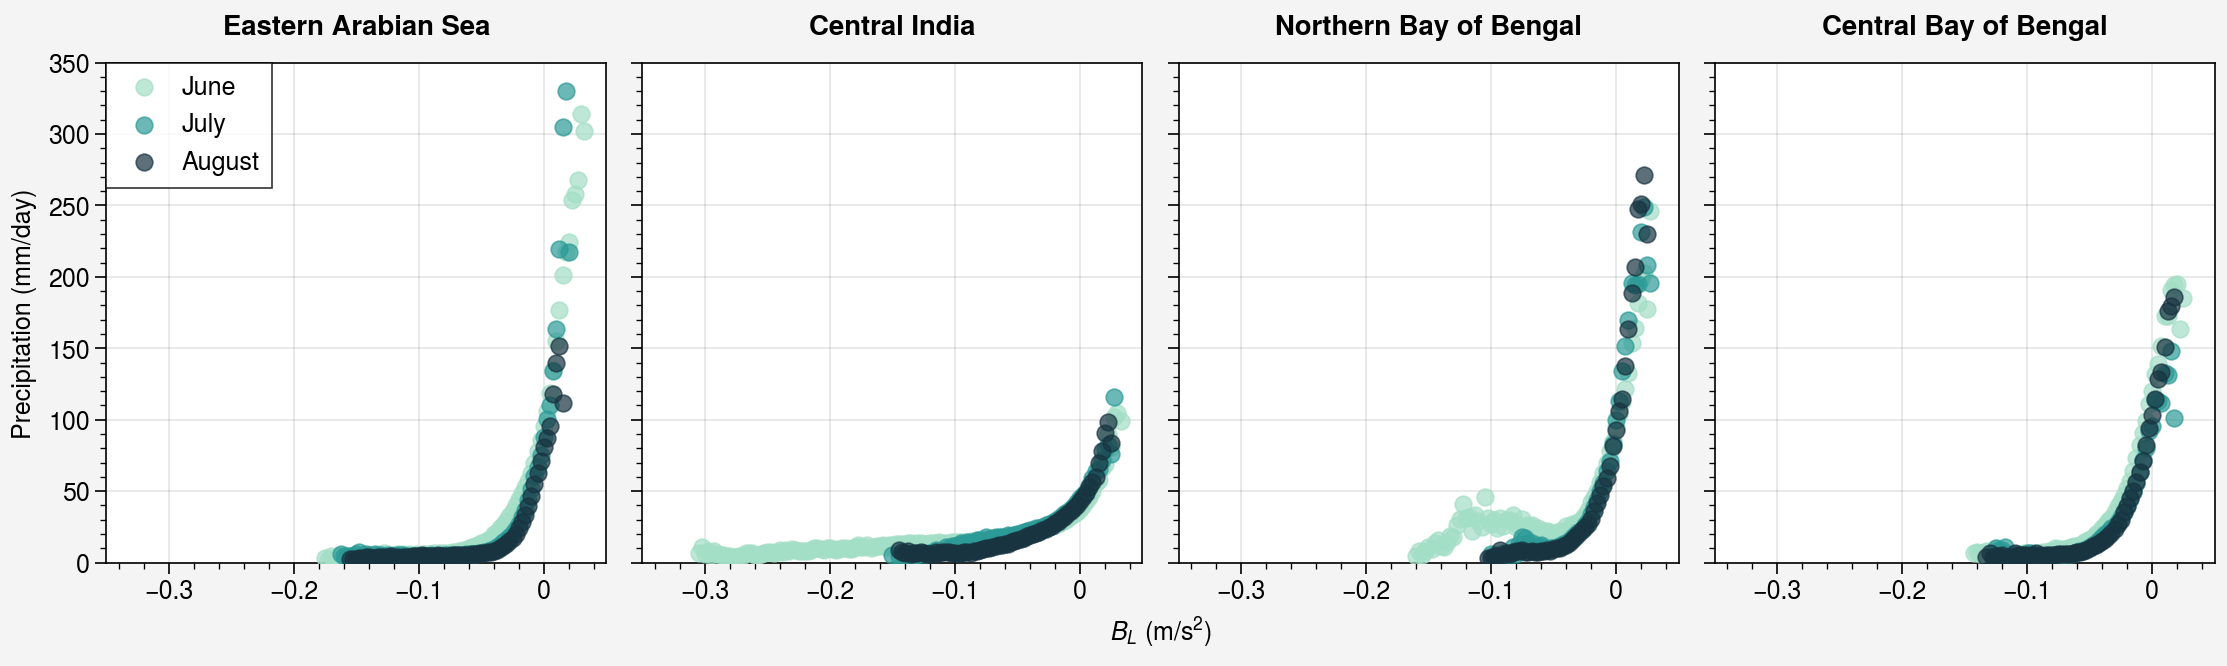

In [59]:
fig,axs = pplt.subplots(nrows=1,ncols=len(regions),share=True,span=True)
axs.format(collabels=REGIONS.keys(),
           xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.35,0.05),xticks=0.1,
           ylabel='Precipitation (mm/day)',ylim=(0,350),yticks=50)
for i,region in enumerate(regions):
    regiondata = ds1.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl
        y = get_bin_mean_pr(monthdata)
        axs[i].scatter(x,y,color=color,alpha=0.7,marker='o',label=label,zorder=100)
axs[0].legend(loc='ul',ncols=1)
pplt.show()

In [30]:
def get_bin_mean_pr(monthstats):
    Q0 = monthstats.Q0
    Q1 = monthstats.Q1
    Q0[Q0==0.0] = np.nan
    Q = Q1/Q0
    return Q

def get_bin_mean_pr_sample_thresh(monthstats,samplethresh=50):
    Q0 = monthstats.Q0
    Q1 = monthstats.Q1
    Q0[Q0==0.0] = np.nan
    Q = Q1/Q0
    Q[Q0<samplethresh] = np.nan
    return Q

def mask_by_ci_thresh(Q0):
    mean = np.mean(Q0)
    sem  = stats.sem(Q0,nan_policy='omit')
    ci   = stats.t.interval(0.95,len(Q0)-1,loc=mean,scale=sem)
    thresh = ci[0]
    masked = np.where(Q0>=thresh,Q0,np.nan)
    return masked

def get_bin_mean_pr_ci_mask(monthstats):
    Q0 = mask_by_ci_thresh(monthstats.Q0) 
    Q1 = monthstats.Q1
    Q0[Q0==0.0] = np.nan
    Q = Q1/Q0
    return Q

def get_fit_xthresh(x,y,xthresh):
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    def expfunc(x,a,b,c):
        return a*np.exp(b*x)+c
    params,_ = curve_fit(f=expfunc,xdata=x[x<=xthresh],ydata=y[x<=xthresh],maxfev=20000)
    a,b,c = params
    def piecewise_func(xval):
        exppart = a*np.exp(b*xval)+c
        yatthresh = a*np.exp(b*xthresh)+c
        slope = a*b*np.exp(b*xthresh)
        linpart = yatthresh+slope*(xval-xthresh)
        return np.where(xval<=xthresh,exppart,linpart)
    return piecewise_func

def interp_from_fit_xthresh(xfit,yfit,x,xthresh):
    f = get_fit_xthresh(xfit,yfit,xthresh)
    y = f(x.values.flatten())
    interped = xr.DataArray(y.reshape(x.shape),dims=x.dims,coords=x.coords)
    return interped

In [32]:
regions    = []
realprlist = []
predprlist = []
predprcilist = []
predprstlist = []
predprlilist = []
for region in REGIONS:
    region1 = ds1.sel(region=region)
    region2 = get_region(ds2,region)
    regions.append(region)
    monthmeanlist = []
    for month in [6,7]:
        month1 = region1.sel(month=month)
        month2 = get_month(region2,month)
        x   = month1.bl
        y   = get_bin_mean_pr(month1)
        yci = get_bin_mean_pr_ci_mask(month1)
        yst = get_bin_mean_pr_sample_thresh(month1)
        predpr   = interp_from_fit(x,y,month2.bl)
        predprci = interp_from_fit(x,yci,month2.bl)
        predprst = interp_from_fit(x,yst,month2.bl)
        predprli = interp_from_fit_xthresh(x,y,month2.bl,xthresh=0.02)
        month2 = month2.assign({'predpr':predpr,'predprci':predprci,'predprst':predprst,'predprli':predprli})
        monthmean = calc_monthly_mean(month2)
        monthmeanlist.append(monthmean)        
    diff = (monthmeanlist[1]-monthmeanlist[0])
    realprlist.append(calc_regional_mean(diff.pr))
    predprlist.append(calc_regional_mean(diff.predpr))
    predprcilist.append(calc_regional_mean(diff.predprci))
    predprstlist.append(calc_regional_mean(diff.predprst))
    predprlilist.append(calc_regional_mean(diff.predprli))

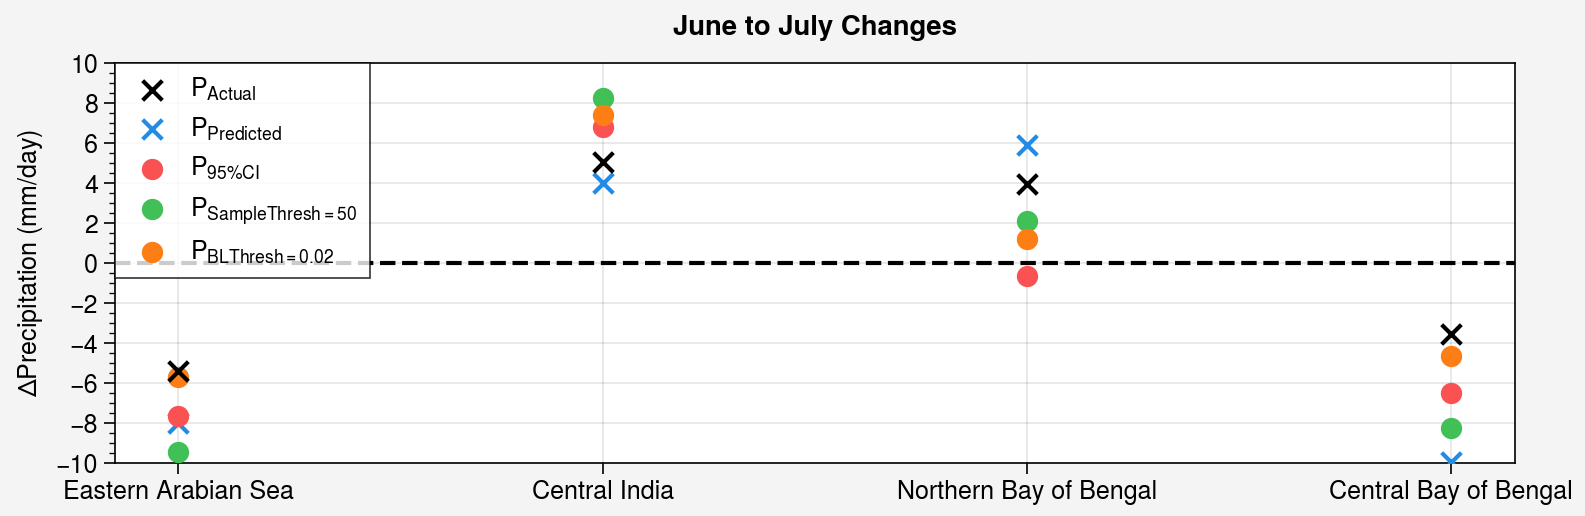

In [33]:
fig,ax = pplt.subplots(refheight=2,refwidth=7)
ax.format(suptitle='June to July Changes',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-10,10),yticks=2)
ax.scatter(regions,realprlist,color='k',marker='x',s=50,label='$P_{Actual}$',zorder=4)
ax.scatter(regions,predprlist,color='blue6',marker='x',s=50,label='$P_{Predicted}$',zorder=3)
ax.scatter(regions,predprcilist,color='red6',marker='o',s=50,label='$P_{95\% CI}$',zorder=3)
ax.scatter(regions,predprstlist,color='green6',marker='o',s=50,label='$P_{Sample Thresh = 50}$',zorder=3)
ax.scatter(regions,predprlilist,color='orange6',marker='o',s=50,label='$P_{BLThresh = 0.02}$',zorder=3)
ax.axhline(y=0,color='k',linestyle='--')
ax.legend(loc='ul',ncols=1)
pplt.show()

In [23]:
#  EAS:  li,  ci, reg, st  
#   CI:  reg, ci,  li, st
# NBOB:  st,  li, reg, ci
# CBOB:  li,  ci,  st, reg

In [ ]:
# li:  1,3,2,1
# ci:  2,2,4,2
# st:  4,4,1,3
# reg: 3,1,3,4

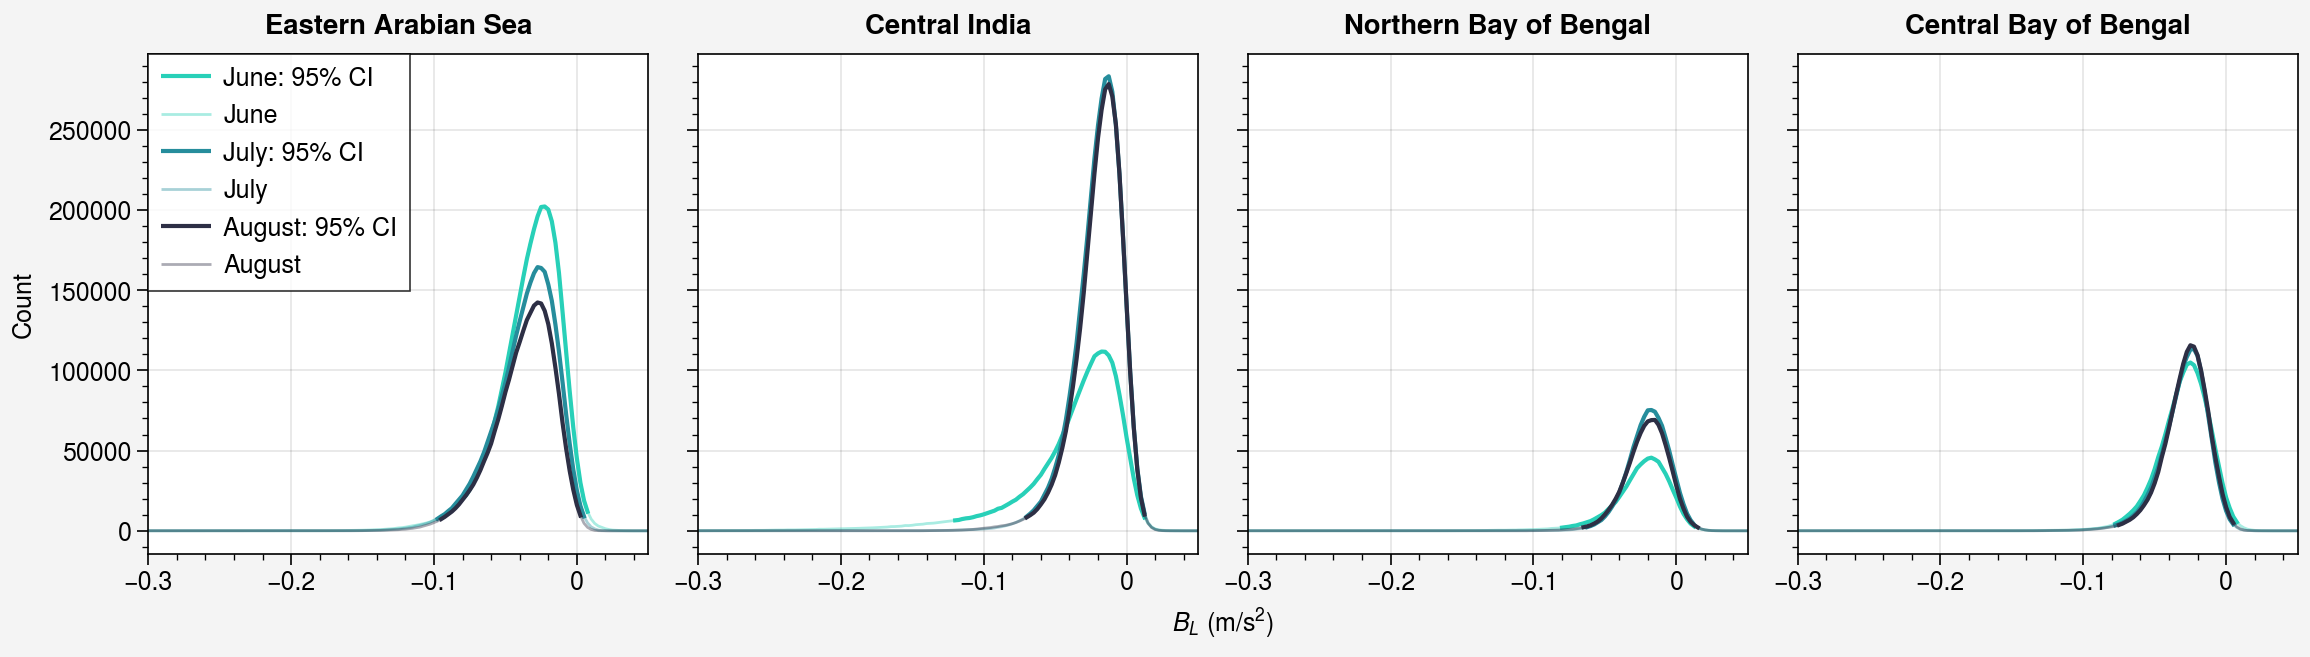

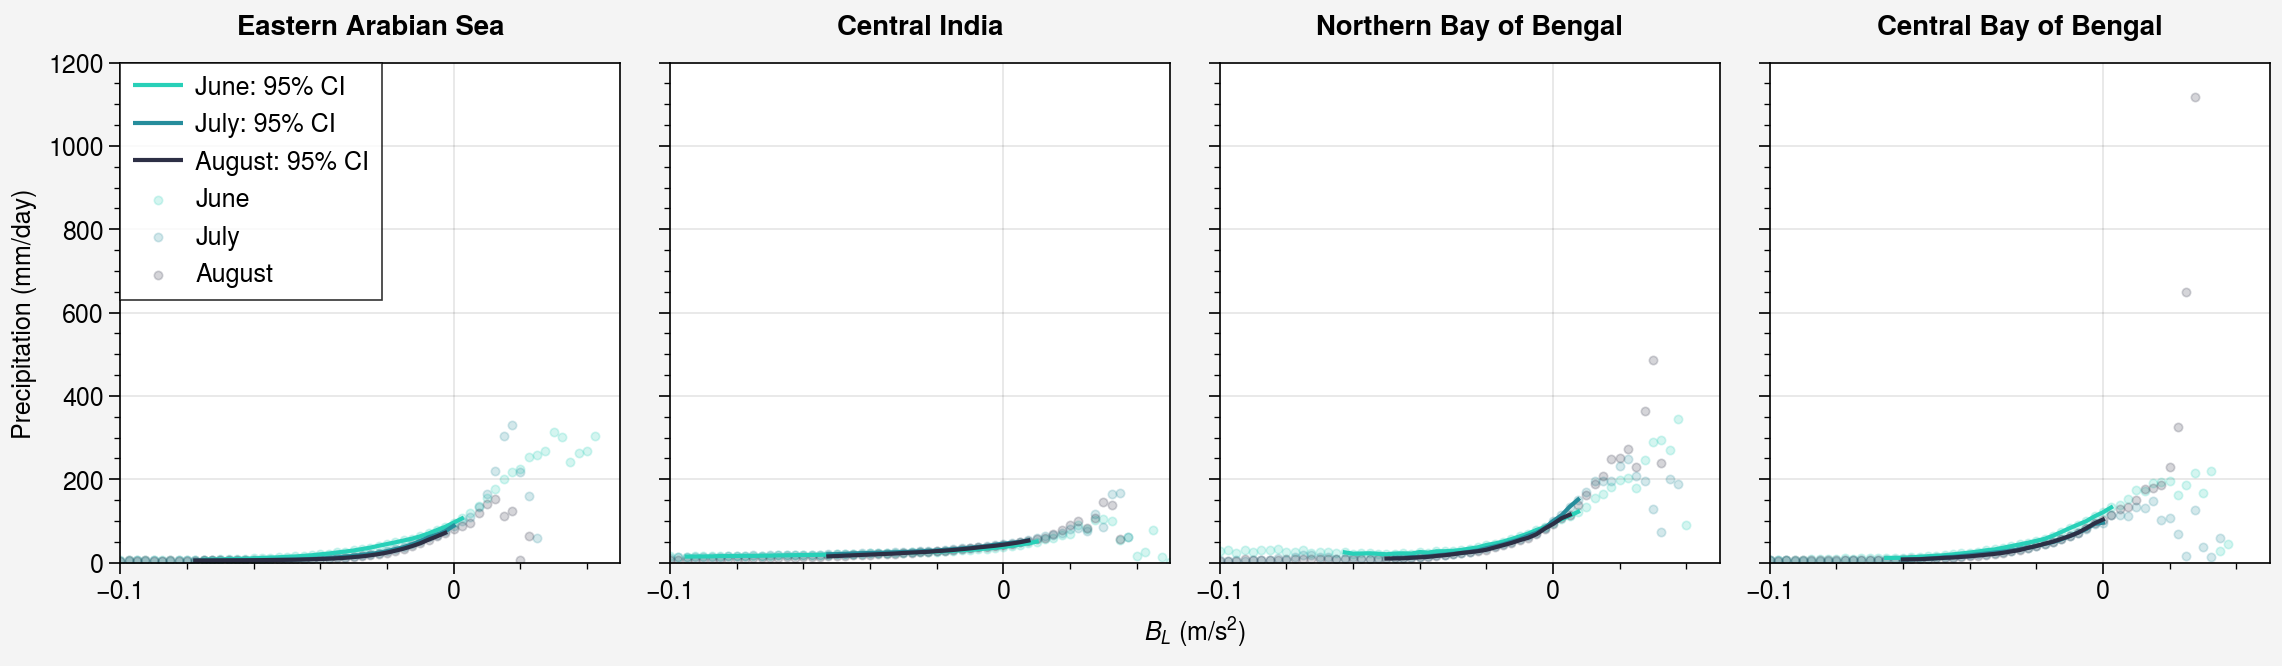

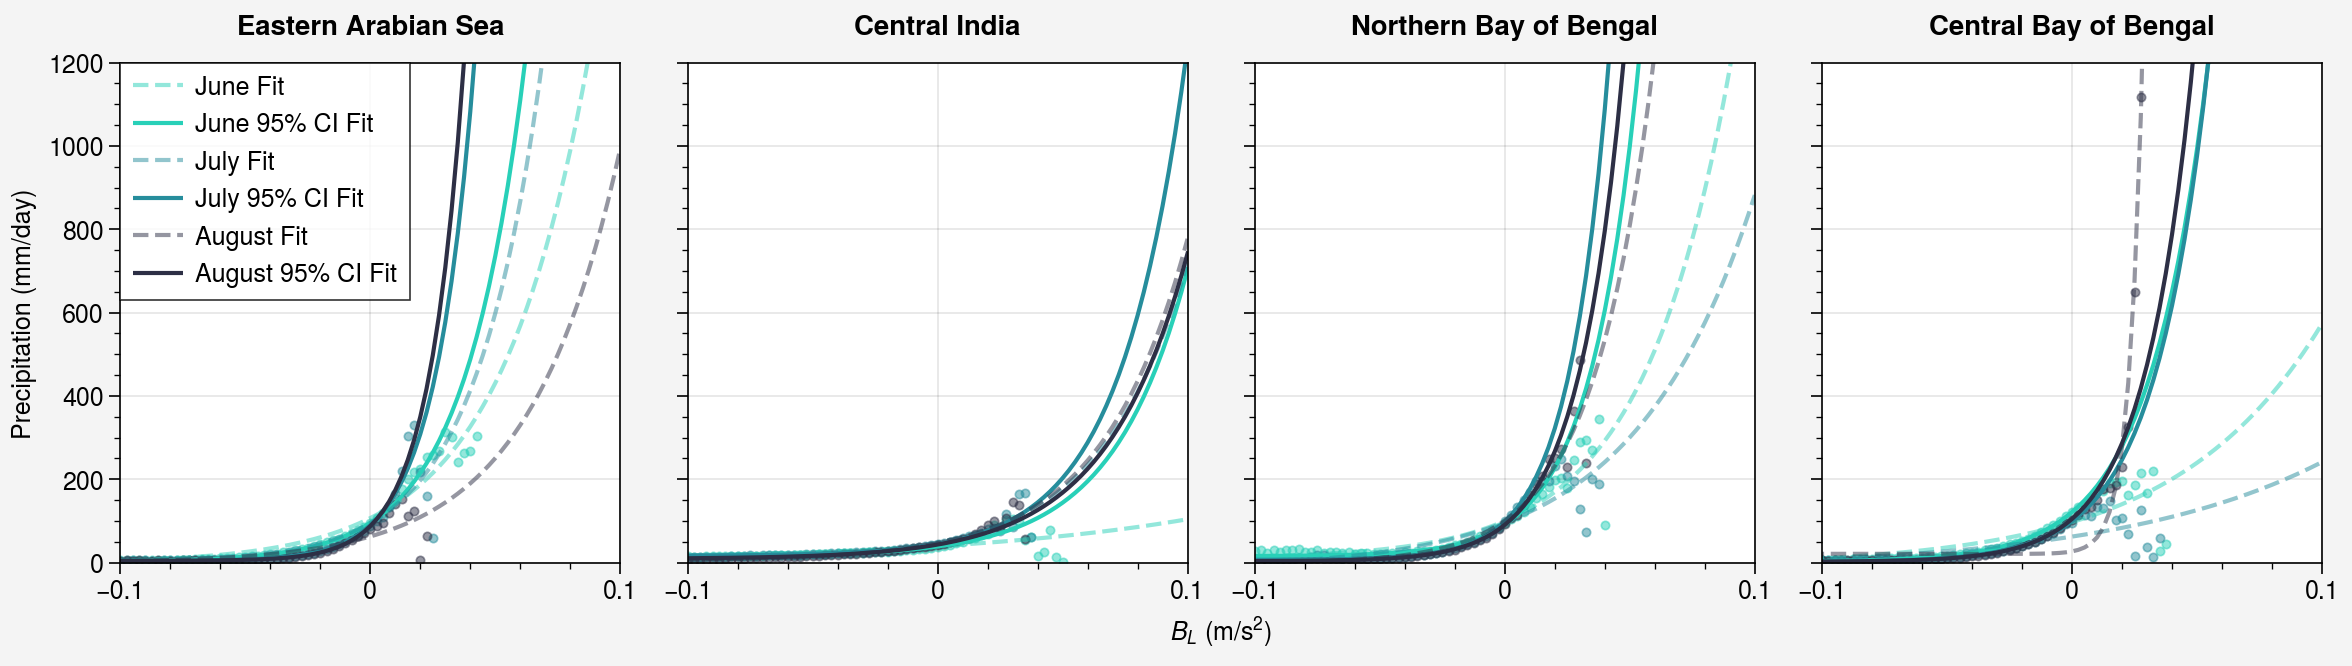

In [33]:
regions = ds1.region.values
months  = ds1.month.values

fig,axs = pplt.subplots(nrows=1,ncols=len(regions),share=True,span=True)
axs.format(collabels=REGIONS.keys(),xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.3,0.05),xticks=0.1,ylabel='Count')
for i,region in enumerate(regions):
    regiondata = ds1.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x  = monthdata.bl
        Q0 = monthdata.Q0
        masked = mask_by_ci_thresh(Q0)
        axs[i].plot(x,masked,color=color,label=f'{label}: 95% CI')
        axs[i].plot(x,Q0,color=color,alpha=0.4,linewidth=1,label=label)
axs[0].legend(loc='ul',ncols=1)
pplt.show()

fig,axs = pplt.subplots(nrows=1,ncols=len(regions),share=True,span=True)
axs.format(collabels=REGIONS.keys(),xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.1,0.05),xticks=0.1,ylabel='Precipitation (mm/day)',ylim=(0,1200),yticks=200)
for i,region in enumerate(regions):
    regiondata = ds1.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl
        y = get_bin_mean_pr(monthdata,mask=False)
        ymasked = get_bin_mean_pr(monthdata,mask=True)
        axs[i].plot(x,ymasked,color=color,label=f'{label}: 95% CI')
        axs[i].scatter(x,y,color=color,alpha=0.2,marker='.',label=label)
axs[0].legend(loc='ul',ncols=1)
pplt.show()

fig,axs = pplt.subplots(nrows=1,ncols=len(regions),share=True,span=True)
axs.format(collabels=REGIONS.keys(),xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.1,0.1),xticks=0.1,ylabel='Precipitation (mm/day)',ylim=(0,1200),yticks=200)
for i,region in enumerate(regions):
    regiondata = ds1.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl
        y = get_bin_mean_pr(monthdata,mask=False)
        f = get_fit(x,y)
        ymasked = get_bin_mean_pr(monthdata,mask=True)
        fmasked = get_fit(x,ymasked)
        axs[i].scatter(x,y,color=color,marker='.',alpha=0.5)
        # axs[i].scatter(x,ymasked,color=color,marker='.',alpha=0.5,label=label)
        axs[i].plot(x,f(x),color=color,linestyle='--',alpha=0.5,label=f'{label} Fit')
        axs[i].plot(x,fmasked(x),color=color,label=f'{label} 95% CI Fit')
axs[0].legend(loc='ul',ncols=1)
pplt.show()

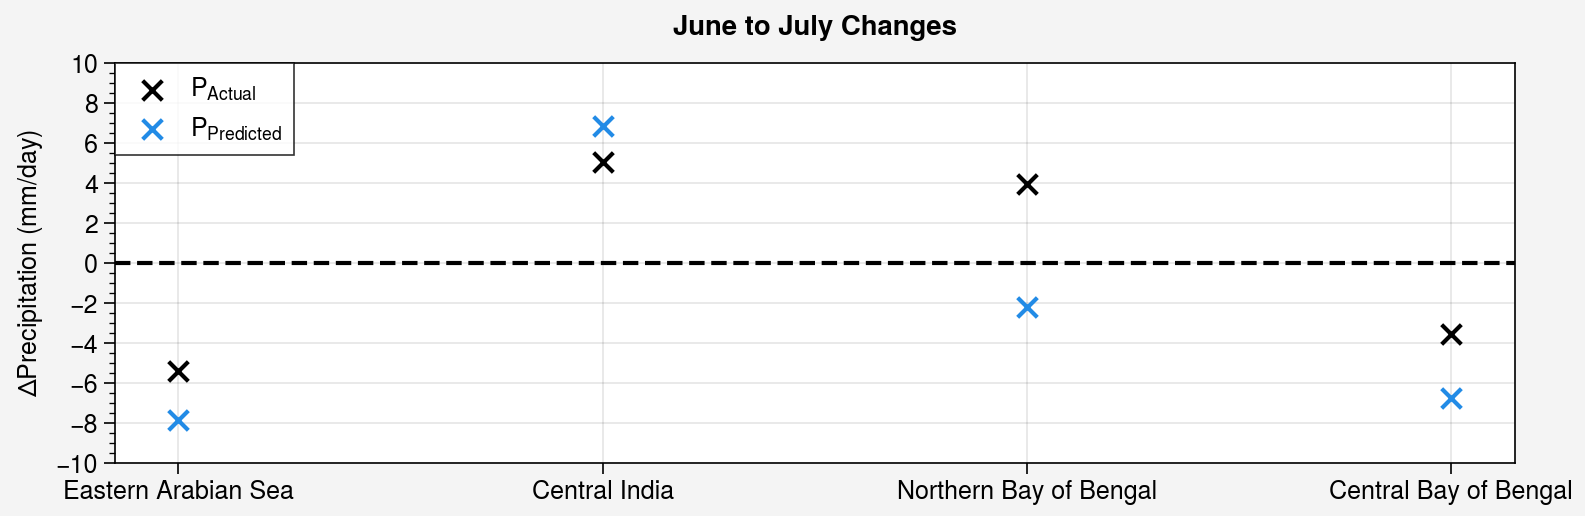

In [ ]:
difflist   = []
realprlist = []
predprlist = []
bllist     = []
capelist   = []
subsatlist = []
for region in REGIONS:
    region1 = ds1.sel(region=region)
    region2 = get_region(ds2,region)
    monthmeanlist = []
    for month in [6,7]:
        month1 = region1.sel(month=month)
        month2 = get_month(region2,month)
        x = month1.bl
        y = get_bin_mean_pr(month1,mask=True)
        predpr = interp_from_fit(x,y,month2.bl)
        month2 = month2.rename({'pr':'realpr'}).assign({'predpr':predpr})
        monthmean = calc_monthly_mean(month2)
        monthmeanlist.append(monthmean)        
    diff = (monthmeanlist[1]-monthmeanlist[0])
    difflist.append(diff)
    realprlist.append(calc_regional_mean(diff.realpr))
    predprlist.append(calc_regional_mean(diff.predpr))
    bllist.append(calc_regional_mean(diff.bl))
    capelist.append(calc_regional_mean(diff.cape))
    subsatlist.append(calc_regional_mean(diff.subsat))
componentlist = [cape-subsat for cape,subsat in zip(capelist,subsatlist)]

# kwargs = dict(cmap='DryWet',vmin=-10,vmax=10,levels=22,extend='both')
# for i,key in enumerate(REGIONS):
#     region = REGIONS[key] 
#     fig,axs = pplt.subplots(nrows=1,ncols=3,proj='cyl')
#     axs.format(rowlabels=[f'{key}'],coast=True,latlines=2,lonlines=2,lonlabels='b',
#                latlim=(region['latmin'],region['latmax']),lonlim=(region['lonmin'],region['lonmax']),
#                collabels=['$\Delta P_{Actual}$','$\Delta P_{Predicted}$','$\Delta P_{Actual} - \Delta P_{Predicted}$'])
#     axs[0].format(latlabels='l')
#     a = axs[0].pcolormesh(difflist[i].realpr,**kwargs)
#     axs[1].pcolormesh(difflist[i].predpr,**kwargs)
#     axs[2].pcolormesh(difflist[i].realpr-difflist[i].predpr,**kwargs)
#     fig.colorbar(a,loc='b',label='$\Delta$Precipitation (mm/day)')
# pplt.show()
    
fig,ax = pplt.subplots(refheight=2,refwidth=7)
ax.format(suptitle='June to July Changes',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-10,10),yticks=2)
ax.scatter(regions,realprlist,color='k',marker='x',s=50,label='$P_{Actual}$',zorder=4)
ax.scatter(regions,predprlist,color='blue6',marker='x',s=50,label='$P_{Predicted}$',zorder=3)
ax.axhline(y=0,color='k',linestyle='--')
ax.legend(loc='ul',ncols=1)
pplt.show()

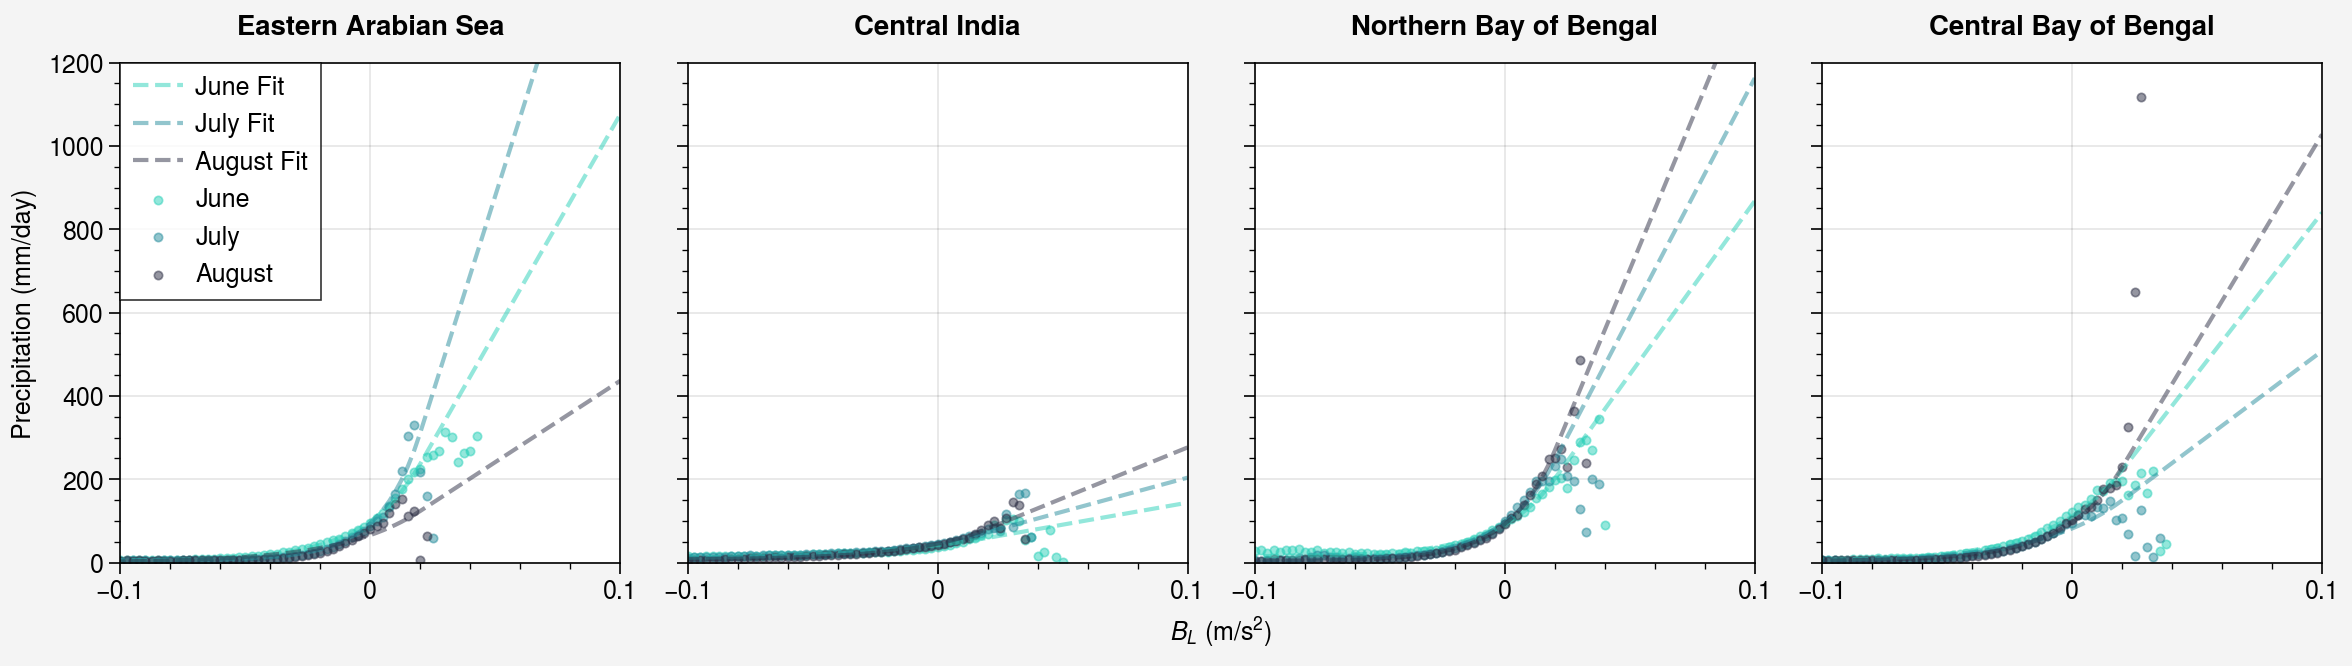

In [35]:
regions = ds.region.values
months  = ds.month.values
fig,axs = pplt.subplots(nrows=1,ncols=len(regions),share=True,span=True)
axs.format(collabels=REGIONS.keys(),xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.1,0.1),xticks=0.1,ylabel='Precipitation (mm/day)',ylim=(0,1200),yticks=200)
for i,region in enumerate(regions):
    regiondata = ds.sel(region=region)
    for month,label,color in CASES:
        monthdata = regiondata.sel(month=month)
        x = monthdata.bl
        y = get_bin_mean_pr(monthdata)
        f = get_fit(x,y,xthresh=0.02)
        axs[i].scatter(x,y,color=color,marker='.',alpha=0.5,label=label)
        axs[i].plot(x,f(x),color=color,linestyle='--',alpha=0.5,label=f'{label} Fit')
axs[0].legend(loc='ul',ncols=1)
pplt.show()